# Detección de Spam con BERT (LLM)
Este cuaderno demuestra el proceso de construcción y evaluación de un modelo basado en BERT (Bidirectional Encoder Representations from Transformers) para la detección de spam.

---

## 1. Introducción a los Modelos de Lenguaje (LLM)
Los Modelos de Lenguaje (LLM, por sus siglas en inglés) son redes neuronales profundas entrenadas en grandes cantidades de datos de texto para comprender y generar lenguaje humano. BERT es un tipo de LLM desarrollado por Google que ha revolucionado el procesamiento del lenguaje natural (NLP).

**Características clave de BERT:**
- **Bidireccional:** Analiza el contexto de una palabra considerando tanto lo que viene antes como después.

- **Basado en Transformers:** Utiliza la arquitectura Transformer con mecanismos de atención.

- **Pre-entrenamiento:** Se entrena primero en tareas generales de lenguaje antes de ser ajustado para tareas específicas.

---
## 2. Importación de librerías
Importamos las librerías necesarias para trabajar con BERT y evaluar el modelo.

In [2]:
import os
import tratarDatos
import numpy as np
import pandas as pd
import torch
import matplotlib.pyplot as plt
from sklearn import metrics
from transformers import BertTokenizer, BertForSequenceClassification
from transformers import Trainer, TrainingArguments
from torch.utils.data import Dataset

---

## 3. Carga y preprocesamiento de datos
Cargamos los datos y los preparamos para el modelo BERT.

In [3]:
# Cargar datos
xtrain, xtest, ytrain, ytest = tratarDatos.combinar_y_dividir_datos()

# Convertir a DataFrame para facilitar el manejo
train_df = pd.DataFrame({'text': xtrain, 'label': ytrain})
test_df = pd.DataFrame({'text': xtest, 'label': ytest})

---
## 4. Tokenización con BERT
BERT requiere una tokenización especial que incluye tokens especiales como [CLS] y [SEP].

In [4]:
# Cargar el tokenizador de BERT
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')

# Función para tokenizar los textos
def tokenize_texts(texts, max_length=128):
    return tokenizer(
        texts.tolist(),
        padding='max_length',
        truncation=True,
        max_length=max_length,
        return_tensors="pt"
    )

# Tokenizar los conjuntos de entrenamiento y prueba
train_encodings = tokenize_texts(train_df['text'])
test_encodings = tokenize_texts(test_df['text'])

---
## 5. Creación del Dataset para PyTorch
Creamos una clase personalizada para manejar los datos.

In [5]:
class SpamDataset(Dataset):
    def __init__(self, encodings, labels):
        self.encodings = encodings
        self.labels = labels

    def __getitem__(self, idx):
        item = {key: val[idx] for key, val in self.encodings.items()}
        item['labels'] = torch.tensor(self.labels[idx])
        return item

    def __len__(self):
        return len(self.labels)

# Crear los datasets
train_dataset = SpamDataset(train_encodings, train_df['label'].values)
test_dataset = SpamDataset(test_encodings, test_df['label'].values)

---
## 6. Configuración del modelo BERT
Cargamos el modelo pre-entrenado y configuramos los parámetros de entrenamiento.

In [6]:
# Cargar el modelo BERT para clasificación de secuencias
modelo = BertForSequenceClassification.from_pretrained(
    'bert-base-uncased',
    num_labels=2  # Spam o Ham
)

# Configurar los argumentos de entrenamiento
training_args = TrainingArguments(
    output_dir='./results',          # Directorio de salida
    num_train_epochs=3,              # Número de épocas
    per_device_train_batch_size=8,   # Tamaño del lote por dispositivo durante el entrenamiento
    per_device_eval_batch_size=16,   # Tamaño del lote por dispositivo durante la evaluación
    warmup_steps=500,                # Número de pasos de calentamiento
    weight_decay=0.01,               # Penalización de peso
    logging_dir='./logs',            # Directorio para logs
    logging_steps=10,
    eval_strategy="epoch"      # Evaluar al final de cada época
)

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


---
## 7. Entrenamiento del modelo
Entrenamos el modelo BERT utilizando el Trainer de Hugging Face.

In [7]:
# Crear el Trainer
trainer = Trainer(
    model=modelo,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=test_dataset
)

# Comenzar el entrenamiento
trainer.train()

Epoch,Training Loss,Validation Loss
1,0.422600,0.144672
2,0.196400,0.107867
3,0.094600,0.096183


TrainOutput(global_step=13575, training_loss=0.12758952896611536, metrics={'train_runtime': 223632.0017, 'train_samples_per_second': 0.486, 'train_steps_per_second': 0.061, 'total_flos': 7142675819857920.0, 'train_loss': 0.12758952896611536, 'epoch': 3.0})

---
## 8. Evaluación del modelo
Evaluamos el modelo utilizando métricas estándar.

Puntuación de precisión: 0.9820
              precision    recall  f1-score   support

        Spam       0.98      0.99      0.98      8921
         Ham       0.98      0.98      0.98      6592

    accuracy                           0.98     15513
   macro avg       0.98      0.98      0.98     15513
weighted avg       0.98      0.98      0.98     15513



<Figure size 640x480 with 0 Axes>

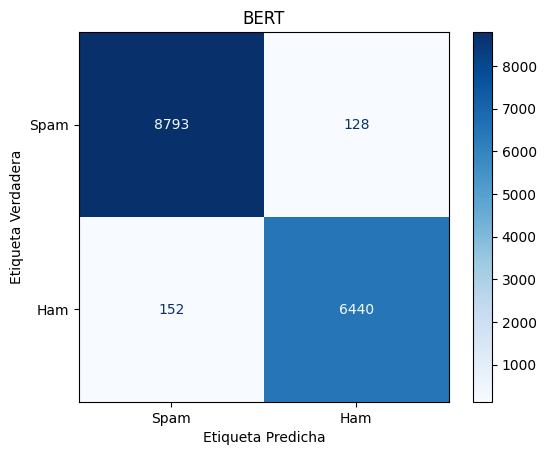

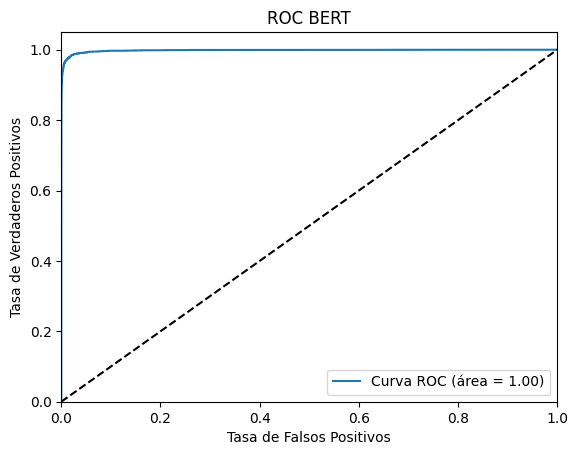

In [8]:
os.makedirs("resultados/LLM", exist_ok=True)

# Función para evaluar el modelo
def evaluate_model(modelo, dataset):
    predicciones = trainer.predict(dataset)
    preds = np.argmax(predicciones.predictions, axis=1)
    
    # Métricas
    precision = metrics.accuracy_score(dataset.labels, preds)
    print(f"Puntuación de precisión: {precision:.4f}")
    
    # Matriz de confusión
    cm = metrics.confusion_matrix(dataset.labels, preds)
    plt.figure()
    disp = metrics.ConfusionMatrixDisplay(cm, display_labels=['Spam', 'Ham'])
    disp.plot(cmap='Blues')  
    plt.xlabel('Etiqueta Predicha')
    plt.ylabel('Etiqueta Verdadera')
    plt.title('BERT')
    plt.savefig('resultados/LLM/BERT_confusion_matrix.png')
    
    # Reporte de clasificación
    print(metrics.classification_report(dataset.labels, preds, target_names=['Spam', 'Ham'], zero_division=1))
    
    # Curva ROC
    probs = torch.softmax(torch.tensor(predicciones.predictions), dim=1)[:, 1].numpy()
    fpr, tpr, _ = metrics.roc_curve(dataset.labels, probs)
    roc_auc = metrics.auc(fpr, tpr)
    
    plt.figure()
    plt.plot(fpr, tpr, label=f'Curva ROC (área = {roc_auc:.2f})')
    plt.plot([0, 1], [0, 1], 'k--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('Tasa de Falsos Positivos')
    plt.ylabel('Tasa de Verdaderos Positivos')
    plt.title('ROC BERT')
    plt.legend(loc="lower right")
    plt.savefig('resultados/LLM/BERT_roc_curve.png')

# Evaluar el modelo
evaluate_model(modelo, test_dataset)